In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'
df = pd.read_csv(url)
df.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int32  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int32(1), int64(5), object(2)
memory usage: 118.6+ KB


In [ ]:
df.card = (df.card == 'yes').astype(int)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1


##### ROC AUC could also be used to evaluate feature importance of numerical variables.

### Let's do that

* For each numerical variable, use it as score and compute AUC with the card variable.
* Use the training dataset for that.
#### If your AUC is < 0.5, invert this variable by putting "-" in front

##### (e.g. -df_train['expenditure'])

#### AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [27]:

numerical = list(df_train.select_dtypes(include=['number' ]))
categorical = list(df_train.select_dtypes(include=['object']))


In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

### Which numerical variable (among the following 4) has the highest AUC?



In [41]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


#### Among the numerical variables (reports,dependents, active and share) that has the highest AUC is...
### Answer: share

## Question 2
#### What's the AUC of this model on the validation dataset? (round to 3 digits)

In [47]:
# First apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Training the model
#### From now on, we only use these columns only:


In [46]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

dv = DictVectorizer(sparse=False)

train_dicts = df_train[columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

## AUC

In [48]:
roc_auc_score(y_val, y_pred)


0.995171242063847

## Question 3
#### Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


In [67]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [68]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,211,53,0,0
1,0.01,211,34,0,19
2,0.02,211,31,0,22
3,0.03,211,24,0,29
4,0.04,211,22,0,31


In [69]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

<img src="r.png">

<img src="p.png">

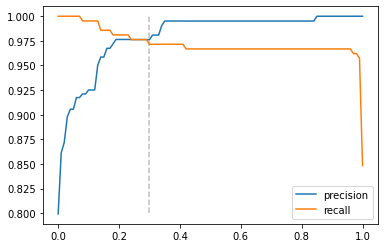

In [73]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.3, 0.8, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

At which threshold precision and recall curves intersect?

Answer: 0.3

## Question 4
#### Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

#### This is the formula for computing :




<center><img src="f1.png" width="180" height="180" ></center>


#### Where P is precision and R is recall.

#### Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

#### At which threshold F1 is maximal?

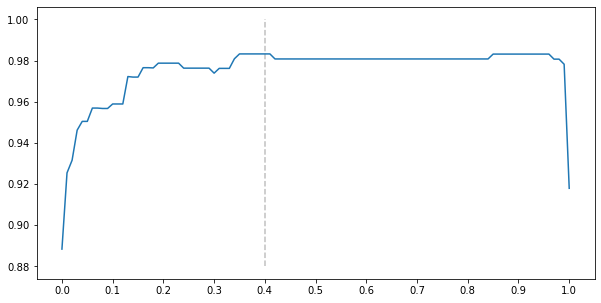

In [86]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.4, 0.88, 1, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### At which threshold F1 is maximal?
#### Answer: 0.4

## Question 5
#### Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

#### KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation


In [92]:
from sklearn.model_selection import KFold

In [93]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [96]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


#### At which threshold F1 is maximal?
#### Answer: 0.4


## Question 6
#### Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 1, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

#### How large is standard devidation of the AUC scores across different folds?

In [99]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.992 +- 0.006
C= 0.1, 0.995 +- 0.004
C=   1, 0.996 +- 0.003
C=  10, 0.996 +- 0.003


#### Which C leads to the best mean score?

##### If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

Answer: 1 and 10, but since 1 is less than 10, the answer is 1

## Ref.

##### https://medium.com/@MohammedS/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b#:~:text=Different%20performance%20metrics%20are%20used,(Area%20under%20Curve)%20etc.